In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
# import dataset into a pandas data frame

df = pd.read_csv('../41467_2022_32829_MOESM5_ESM.csv')
df.head()

,ID,DNA1 [counts],DNA2 [counts],DNA3 [counts],RNA1 [counts],RNA2 [counts],RNA3 [counts],TX1 [au],TX2 [au],TX3 [au],...,high quality,Observed log(TX/Txref),Predicted log(TX/Txref),dG10,dG35,dGDisc,dGITR,dGEXT10,dGSPAC,dGUP
0,0,8263,7261,5173,16341,10320,13506,2.258071,1.523795,1.545541,...,Yes,-3.386326,-3.844827,-1.781524,-1.477218,-0.106428,-0.021112,0.191352,-0.0924,0.400862
1,1,5600,4886,3264,10986,7250,10800,2.240001,1.590845,1.958709,...,Yes,-3.503140,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
2,2,7898,6790,4752,19572,32204,30585,2.829533,5.084911,3.810029,...,Yes,-4.207206,-3.905283,-1.781524,-1.477218,-0.166884,-0.021112,0.191352,-0.0924,0.400862
3,3,10651,9875,6466,15734,16246,18908,1.686729,1.763814,1.731036,...,Yes,-3.392439,-3.877808,-1.781524,-1.477218,-0.139409,-0.021112,0.191352,-0.0924,0.400862
4,4,12188,10793,6965,28609,21796,26803,2.680198,2.165100,2.278025,...,Yes,-3.698903,-3.672384,-1.781524,-1.477218,0.066015,-0.021112,0.191352,-0.0924,0.400862


In [3]:
# All input and output data

X = df['Observed log(TX/Txref)']
y = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]

y.head()

,UP,h35,spacs,h10,disc,ITR
0,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CCCCGCGG,CTCTACCTTAGTTTGTACGTT
1,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGGCGG,CTCTACCTTAGTTTGTACGTT
2,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGCGCCCG,CTCTACCTTAGTTTGTACGTT
3,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,GCGGCGGC,CTCTACCTTAGTTTGTACGTT
4,TTTTCTATCTACGTAC,TTGACA,CTATTTCCTATTTCTCT,TATAAT,CGGGGGGC,CTCTACCTTAGTTTGTACGTT


In [4]:
# remove all rows with spacer sequences that are not 16-18 nucleotides long


_df = df[(df['spacs'].str.len() >= 15) & (df['spacs'].str.len() <= 19)]


X = _df['Observed log(TX/Txref)']
y = _df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]

print(f'Removed {df.shape[0] - _df.shape[0]} rows')


Removed 140 rows


In [5]:
padded_sequences = {}
for col in y.columns:
    max_len = y[col].str.len().max()
    padded_sequences[col] = [str(val).zfill(max_len) for val in y[col]]

# Concatenate padded strings in each row into a single string
y = pd.Series([''.join(row) for row in zip(*padded_sequences.values())])

print(y)


0        000000TTTTCTATCTACGTACTTGACA00CTATTTCCTATTTCTC...
1        000000TTTTCTATCTACGTACTTGACA00CTATTTCCTATTTCTC...
2        000000TTTTCTATCTACGTACTTGACA00CTATTTCCTATTTCTC...
3        000000TTTTCTATCTACGTACTTGACA00CTATTTCCTATTTCTC...
4        000000TTTTCTATCTACGTACTTGACA00CTATTTCCTATTTCTC...
                               ...                        
13336    000000TTTTCTATCTACGTACAATTGA0000TATTTCCTATTTCT...
13337    000000TTTTCTATCTACGTACAATTGA0000TATTTCCTATTTCT...
13338    000000TTTTCTATCTACGTACAATTGA0000TATTTCCTATTTCT...
13339    000000TTTTCTATCTACGTACAATTGA0000TATTTCCTATTTCT...
13340    000000TTTTCTATCTACGTACAATTGA0000TATTTCCTATTTCT...
Length: 13341, dtype: object


In [6]:
y[0]

'000000TTTTCTATCTACGTACTTGACA00CTATTTCCTATTTCTCTTATAATCCCCGCGGCTCTACCTTAGTTTGTACGTT'

In [7]:
X


0       -3.386326
1       -3.503140
2       -4.207206
3       -3.392439
4       -3.698903
           ...   
13476   -3.015626
13477   -2.123137
13478   -2.469796
13479   -2.070331
13480   -1.896021
Name: Observed log(TX/Txref), Length: 13341, dtype: float64

In [8]:
# split the data in training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [24]:
# Define a mapping from DNA characters to integers
char_to_int = {'A': 0, 'T': 1, 'C': 2, 'G': 3, '0': 4}

# Convert DNA sequences to integers
int_sequences = [[char_to_int[char] for char in sequence] for sequence in y_train]

# Pad sequences to have the same length
max_seq_length = max(len(seq) for seq in int_sequences)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(int_sequences, maxlen=max_seq_length, padding='post')

# Repeat each floating-point number to match the length of its corresponding DNA sequence
repeated_X = np.repeat(X_train.values.reshape(-1, 1), max_seq_length, axis=1)

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_seq_length,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.RepeatVector(max_seq_length),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(82, activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.1997 - val_loss: 1.1083
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.0932 - val_loss: 1.0685
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 1.0476 - val_loss: 1.0099
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - loss: 1.0059 - val_loss: 0.9704
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.9673 - val_loss: 0.9356
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - loss: 0.9343 - val_loss: 0.9330
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - loss: 0.9031 - val_loss: 0.8705
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - loss: 0.8627 - val_loss: 0.8719
Epoch 9/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - loss: 0.8416 - val_loss: 0.8164
Epoch 10/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - loss: 0.8143 - val_loss: 0.8103
Epoch 11/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - loss: 0.7983 - val_loss: 0.8016
Epoch 12/50
301/301 ━━━━━━━━━━━━

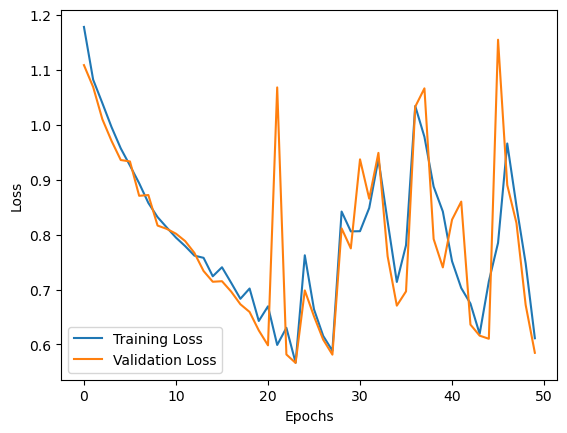

In [29]:
repeated_X_test = np.repeat(X_test.values.reshape(-1, 1), max_seq_length, axis=1)

# Define EarlyStopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
history = model.fit(repeated_X, padded_sequences, epochs=50, batch_size=32, validation_split=0.1)

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
print(history.history['val_loss'])

0.584797203540802


In [30]:
# Convert DNA sequences to integers
encoded_y_test = [[char_to_int[char] for char in sequence] for sequence in y_test]

# Pad sequences to have the same length
padded_sequences_test = tf.keras.preprocessing.sequence.pad_sequences(encoded_y_test, maxlen=max_seq_length, padding='post')

# Repeat each floating-point number to match the length of its corresponding DNA sequence
repeated_X_test = np.repeat(X_test.values.reshape(-1, 1), max_seq_length, axis=1)

# Evaluate on test set
test_loss = model.evaluate(repeated_X_test, padded_sequences_test)
print("Test Loss:", test_loss)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5870
Test Loss: 0.5771316885948181


In [27]:
# save the model

model.save('initial_backward_pred.keras')